**1.   How is Deep learning different from the Neural Networks (ANN) learning and algorithms we studied?**

The performance of the neural networks (ANN) learning and algorithms that we have studied so far hinges on the quality of the features selection, which's mostly done by a programmer or engineer.  These are also known as shallow learners.  A problem associated with shallow learning is the selectivity-invariance dilemma, in which one that produces representations that are selective to the aspects of the image that are important for discrimination, but that are invariant to irrelevant aspects such as the pose of the animal.  A solution to the dilemma is to use generic non-linear features, such as the kernel methods, however, this method doesn't generalize well when applied on test data that are very different from the training dataset, and this leads to the need for intricately designed good feature extractors, which requires considerable engineering skill and domain expertise.  

The above dilemma can be avoided altogether by the use of deep learning architecture because of the method's inherent ability to learn good features automatically using a multilayer stack of simple modules, most of which are subject to learning, and each module in the stack transforms its input to increase both the selectivity and the invariance of the representation.

To recap, the main difference between deep learning and the others that we've covered so far resides in DL's ability to learn good features as opposed to the others' dependency on hand-engineered features selection.  

**2. TensorFlow Implementation:**

https://www.datacamp.com/community/tutorials/tensorflow-tutorial.

Using Tensor Flow, implement multiclass classification via Deep Learning CNNs for a different use case following the tutorial.  

Use another dataset from the following sources:  https://www.tensorflow.org/datasets.

Explain the results. 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from tensorflow import*
import tensorflow_datasets as tfds

# to enable eager execution -> click on Runtime -> Reset all runtimes

tf.enable_eager_execution()

### *Trial Data Pre-processing*

In [2]:
# show all datasets available in TensorFlow_datasets
print(tfds.list_builders()[20:30])

['diabetic_retinopathy_detection',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eurosat',
 'fashion_mnist',
 'flores']


### ***Loading dataset***

In [0]:
from tensorflow.examples.tutorials.mnist import input_data

ds = input_data.read_data_sets('data/fashion', one_hot=False)

In [4]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=ds.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=ds.train.labels.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=ds.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=ds.test.labels.shape))

Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000,)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000,)


### ***Pre-processing data***

In [5]:
# checking image normalization by checking whether values range between 0 and 1 inclusive

print("Max value in all 'images' features is: {}".format(np.max(ds.train.images)))
print("Min value in all 'images' features is: {}".format(np.min(ds.train.images)))

Max value in all 'images' features is: 1.0
Min value in all 'images' features is: 0.0


In [6]:
# Reshape training and testing image
# 'images' - input features

train_X = ds.train.images
test_X = ds.test.images

# checking reshaped dimensions
train_X.shape, test_X.shape

((55000, 784), (10000, 784))

In [7]:
train_y = ds.train.labels.astype(int)
test_y = ds.test.labels.astype(int)

# checking labels
train_y.shape, test_y.shape

((55000,), (10000,))

### ***CNN: TensorFlow Implementation***

In [0]:
def cnn_model(features, labels, mode):
  
  input_layer = tf.reshape(tensor = features["x"],shape =[-1, 28, 28, 1])
  
  conv1 = tf.layers.conv2d(inputs = input_layer,
                           filters = 32,
                           kernel_size=[5,5],
                           padding = "same",
                           activation = tf.nn.relu)
  
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
  
  conv2 = tf.layers.conv2d(inputs=pool1,
                           filters=36,
                           kernel_size = [5,5],
                           padding = "same",
                           activation = tf.nn.relu)
  
  pool2 = tf.layers.max_pooling2d(inputs = conv2, pool_size=[2,2], strides=2)
   
  # flatten for dense layer input
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 36])
  
  dense = tf.layers.dense(inputs=pool2_flat, units=7 * 7 * 36, activation=tf.nn.relu)
  
  dropout = tf.layers.dropout(inputs=dense, rate=0.4, training= mode==tf.estimator.ModeKeys.TRAIN)
  print("dropout shape: {}\n".format(dropout.shape))
  
  logits = tf.layers.dense(inputs=dropout, units=10)
  print("logits shape: {}\n".format(logits.shape))
  
  # generate predictions (for PREDICT and EVAL mode)
  predictions = {"classes": tf.argmax(input = logits, axis=1),
                "probablities": tf.nn.softmax(logits, name="softmax_tensor")}
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
  
  # Calculate Loss
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss=loss,
                                  global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics Evaluation mode
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(labels=labels,
                                      predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
  

In [0]:
# Create the Estimator
classifier = tf.estimator.Estimator(
    model_fn=cnn_model, model_dir="train/fashion_mnist_convnet_model")

In [0]:
# Set up logging for predictions

tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

In [19]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_X},
    y=train_y,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

classifier.train(
    input_fn=train_input_fn,
    steps=16000,
    hooks=[logging_hook])

W0724 05:15:33.209820 140583956191104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1066: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


In [27]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_X},
    y=test_y,
    num_epochs=1,
    shuffle=False)
eval_results = classifier.evaluate(input_fn=eval_input_fn)
print("\nEvaluation Metrics: {}".format(eval_results))


Evaluation Metrics: {'accuracy': 0.9786, 'loss': 0.070605636, 'global_step': 32000}


*CNN TensorFlow Implementation on Fashion MNIST dataset yields: **97.9%** accuracy*

### ***CNN: Keras Implementation***

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, utils

In [0]:
ds = datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = ds.load_data()

In [76]:
# check feature values for normalization
print("X_train value range: {min} thru {max}".format(max=np.max(X_train), min=np.min(X_train)))
print("X_test value range: {min} thru {max}".format(max=np.max(X_test), min=np.min(X_test)))

X_train value range: 0 thru 255
X_test value range: 0 thru 255


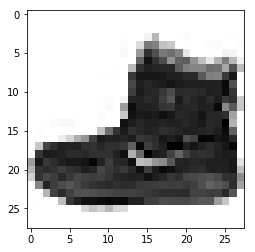

In [0]:
# visualize the first X_train element
plt.imshow(X_train[0],cmap=plt.cm.binary)

In [0]:
# normalize feature values
X_train = utils.normalize(X_train, axis=1)
X_test = utils.normalize(X_test, axis=1)

In [0]:
# check min and max feature values to ensure normalization

print("X_train value range: {min} thru {max}".format(max=np.max(X_train), min=np.min(X_train)))
print("X_test value range: {min} thru {max}".format(max=np.max(X_test), min=np.min(X_test)))

X_train value range: 0.0 thru 1.0
X_test value range: 0.0 thru 1.0


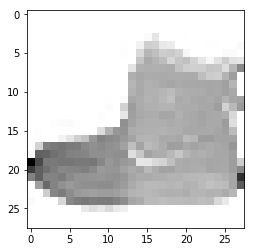

In [0]:
# same element as prior to normalziation of X_train 
plt.imshow(X_train[0],cmap=plt.cm.binary)

In [0]:
X_train.shape

(60000, 28, 28)

In [0]:
# reshape for model input
X_train = X_train.reshape((60000, 28, 28, 1))

In [0]:
X_test.shape

(10000, 28, 28)

In [0]:
# reshape for model input
X_test = X_test.reshape((10000, 28, 28, 1))

***Creating CNN Model***

In [0]:
model = models.Sequential()

# convolutional base
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# dense layers for classification output
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)               

***Compiling and Training***

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.3937 - acc: 0.8533
Epoch 2/10
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.3357 - acc: 0.8762
Epoch 3/10
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.2985 - acc: 0.8888
Epoch 4/10
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.2721 - acc: 0.8985
Epoch 5/10
60000/60000 [==============================] - 76s 1ms/sample - loss: 0.2503 - acc: 0.9065
Epoch 6/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.2312 - acc: 0.9127
Epoch 7/10
60000/60000 [==============================] - 76s 1ms/sample - loss: 0.2136 - acc: 0.9194
Epoch 8/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.1996 - acc: 0.9241
Epoch 9/10
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.1858 - acc: 0.9297
Epoch 10/10
60000/60000 [==============================] - 79s 1ms/sample - loss: 

***Model Evaluation***

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 4s 378us/sample - loss: 0.3106 - acc: 0.8980


In [0]:
print("Test accuracy of CNN model on the fashion MNIST dataset is: {:0.2f}%".format(test_acc*100))

Test accuracy of CNN model on the fashion MNIST dataset is: 89.80%
